In [1]:
import torch
import torchvision.datasets
import torchvision.models
import torchvision.transforms
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
from PIL import Image, ImageOps
import os, sys, math, random, copy, time
import datasets, custom_transforms, models
import cv2
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

cuda:0


# Settings

In [2]:
# Parameters
N_CLASSES = 2
BATCH_SIZE = 4
num_epochs=15

TRAIN_DATA_DIR = 'D:/data/DanielCustomNetwork/DanielDataSets_Reduced_256_None/train/'
VAL_DATA_DIR = 'D:/data/DanielCustomNetwork/DanielDataSets_Reduced_256_None/val/'
save_folder_name =  "VGG16_Rajaraman_NoSuppression"




# LOCKED
# Preprocessing settings:
interp_mode = torchvision.transforms.InterpolationMode.NEAREST
image_size_to_VGG =224 # resize input images to this size in VGG
top_cutoff_percent = 0.08 # COVID-Net paper by Wang et al.
model_name = "VGG"
num_channels = 3 # because VGG is trained on RGB images
unbias=True
limit_save_epoch_acc=0.95
limit_save_epoch_loss = 0.13

# Learning Rates
betas = (0.9,0.999)
ini_lr= 1e-3
max_layers_to_freeze = 28 # 30 means that only the last linear classifier is left to train
class_weights = torch.Tensor([1, 1000/896]) # NONCOVID, COVID

checkpoint_save_path=os.path.join('checkpoints', str(N_CLASSES)+"Class", save_folder_name ,str(max_layers_to_freeze))
a = Path(checkpoint_save_path)
a.mkdir(parents=True, exist_ok=True)

# Data Preprocessing

In [3]:
# Data Preprocessing and Transforms
# Assumes importing images as PIL Images
normalize = torchvision.transforms.Normalize(
                                [0.485, 0.456, 0.406],
                                [0.229, 0.224, 0.225])

class Equalise(object):
    # Histogram equalisation
    # Only works on PIL images
    def __init__(self, mask=None):
        self.mask = mask
    def __call__(self, image):
        return ImageOps.equalize(image, self.mask)
    
class ImageComplement(object):
    # Flip image intensities (i.e. black becomes white, white becomes black)
    # Assumes input image is a tensor with range[0,1]
    def __init__(self, probability=0.5):
        self.probability = probability
    def __call__(self, image):
        activate = np.random.uniform(0,1)
        if activate < self.probability:
            # Flip
            max_image = torch.max(image)
            min_image = torch.min(image)
            #print("min:{},max:{}".format(min_image, max_image))
            image = (image-min_image)/(max_image-min_image) # range [0,1]
            image = (1-image)*(max_image-min_image) + min_image # back to original range
        return image



train_transforms=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    custom_transforms.COVIDNetProcessing(top_cutoff_percent),
                                    torchvision.transforms.Resize(image_size_to_VGG, interpolation=interp_mode), # PIL image
                                    torchvision.transforms.CenterCrop(image_size_to_VGG),
                                    torchvision.transforms.RandomHorizontalFlip(),
                                    torchvision.transforms.ColorJitter(brightness=0.1), # this jitters brightness
                                    torchvision.transforms.RandomAffine(degrees=10,translate=(0.1,0.1),scale=(0.9,1.1)),
                                    ImageComplement(),
                                    normalize,
                                    ])

val_transforms=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    custom_transforms.COVIDNetProcessing(top_cutoff_percent),
                                    torchvision.transforms.Resize(image_size_to_VGG, interpolation=interp_mode),
                                    torchvision.transforms.CenterCrop(image_size_to_VGG),
                                    normalize,
                                ])

import datasets
train_dataset = datasets.Coviddataset(normal_path=os.path.join(TRAIN_DATA_DIR,"NORMAL"),
                                      pneumonia_path=os.path.join(TRAIN_DATA_DIR,"PNEUMONIA"),
                                      covid_path=os.path.join(TRAIN_DATA_DIR,"COVID"),
                                      transform = train_transforms,
                                     NClasses=N_CLASSES, unbias=unbias,channels=num_channels)
val_dataset = datasets.Coviddataset(normal_path=os.path.join(VAL_DATA_DIR,"NORMAL"),
                                    pneumonia_path=os.path.join(VAL_DATA_DIR,"PNEUMONIA"),
                                    covid_path=os.path.join(VAL_DATA_DIR,"COVID"),
                                    transform = val_transforms,
                                   NClasses=N_CLASSES, unbias=unbias, channels=num_channels )

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE,shuffle=True, num_workers=0, pin_memory=True)

dataloaders = {'train':train_loader,'val':val_loader}
train_number=len(train_dataset);val_number=len(val_dataset)
dataset_sizes={'train':train_number,'val':val_number}

RAW DATASET STATISTICS:-----------
Normal:1000, Pneumonia:1000, COVID:896
2-Class Dataset Statistics:-----------
Noncovid:1000, COVID:896
RAW DATASET STATISTICS:-----------
Normal:100, Pneumonia:100, COVID:100
2-Class Dataset Statistics:-----------
Noncovid:100, COVID:100


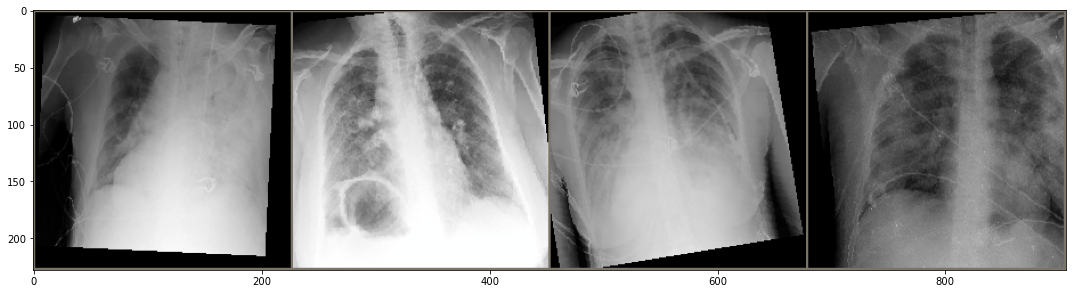

In [4]:
# DEBUGGING
sample = next(iter(dataloaders["train"]))
out = torchvision.utils.make_grid(sample["image"])
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
imshow(out)

# Network

In [5]:
import models
model = models.VGG16_Rajaraman(N_CLASSES, max_layer_to_freeze=max_layers_to_freeze, verbose=False)
print(model)
model = model.to(device)

# Loss
criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=ini_lr, betas=betas)

# Deterministic
torch.backends.cudnn.benchmark = False

Parameters total:  14715714
Parameters trainable:  2360834
VGG16_Rajaraman(
  (vgg16_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, scheduler=None, is_inception=False):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    
    history_accuracy = {"train":[], "val":[]}
    history_loss = {"train":[], "val":[]}
    best_loss = 1.0
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in history_loss.keys():
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                inputs=data["image"]
                labels=data["label"]
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            # Record histories
            history_accuracy[phase].append(epoch_acc)
            history_loss[phase].append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > limit_save_epoch_acc and epoch_loss < limit_save_epoch_loss:
                best_loss = epoch_loss
                best_acc = epoch_acc
                print("Achieved current lowest loss of: {} ; accuracy = {}".format(best_loss, epoch_acc))
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': best_model_wts,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'N_CLASSES': N_CLASSES,
                    'BATCH_SIZE': BATCH_SIZE,
                    'ini_lr': ini_lr,
                    'max_layers_to_freeze':max_layers_to_freeze,
                    'class_weights':class_weights,
                    'random_seed': seed
                }, os.path.join(checkpoint_save_path,
                                'balance[epoch_{}_loss_{:.3f}_acc_{:.3f}].pt'.format((epoch), history_loss[phase][-1],
                                                                                            history_accuracy[phase][-1])))
            
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    history = {"accuracy":history_accuracy, "loss":history_loss}
    return model, history


def set_parameter_requires_grad(model, feature_extracting):
    # If feature extracting only.
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [7]:
model, history = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------


C:\Users\nfdlam\.conda\envs\AI_cuda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.3315 Acc: 0.8840
val Loss: 0.0952 Acc: 0.9650
Achieved current lowest loss of: 0.09522169364441652 ; accuracy = 0.965

Epoch 1/14
----------
train Loss: 0.1700 Acc: 0.9457
val Loss: 0.0886 Acc: 0.9700
Achieved current lowest loss of: 0.08855715200993018 ; accuracy = 0.97

Epoch 2/14
----------
train Loss: 0.1436 Acc: 0.9436
val Loss: 0.0800 Acc: 0.9800
Achieved current lowest loss of: 0.07995531135547936 ; accuracy = 0.98

Epoch 3/14
----------
train Loss: 0.1252 Acc: 0.9599
val Loss: 0.0638 Acc: 0.9850
Achieved current lowest loss of: 0.06381324285835036 ; accuracy = 0.985

Epoch 4/14
----------
train Loss: 0.1284 Acc: 0.9589
val Loss: 0.0597 Acc: 0.9800
Achieved current lowest loss of: 0.05966761449043588 ; accuracy = 0.98

Epoch 5/14
----------
train Loss: 0.1007 Acc: 0.9662
val Loss: 0.0774 Acc: 0.9750
Achieved current lowest loss of: 0.07741512623620395 ; accuracy = 0.975

Epoch 6/14
----------
train Loss: 0.1239 Acc: 0.9589
val Loss: 0.0880 Acc: 0.9750
Achieved curr

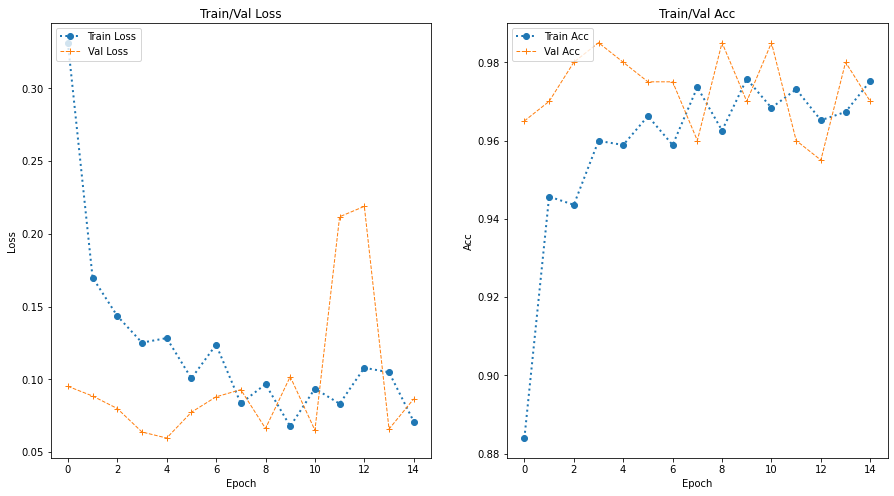

In [8]:
# Graph Visualisation
import matplotlib.pyplot as plt

epoch_list= list(i for i in range(0,num_epochs))

fig, ax = plt.subplots(1,2, figsize=(15,8))
ax[0].set(title='Train/Val Loss', xlabel='Epoch', ylabel='Loss' )
ax[0].plot(epoch_list, history["loss"]['train'],linewidth=2,linestyle=':',label='Train Loss', marker='o')
ax[0].plot(epoch_list, history["loss"]['val'], linewidth=1, linestyle='--', label='Val Loss', marker='+')
ax[0].legend(loc=2)

ax[1].set(title='Train/Val Acc', xlabel='Epoch', ylabel='Acc' )
ax[1].plot(epoch_list, history["accuracy"]['train'], linewidth=2, linestyle=':', label='Train Acc', marker='o')
ax[1].plot(epoch_list, history["accuracy"]['val'], linewidth=1, linestyle='--', label='Val Acc', marker='+')
ax[1].legend(loc=2)
plt.savefig(os.path.join(checkpoint_save_path,"lossaccpic_"+str(N_CLASSES)+"class.png"), bbox_inches='tight')

plt.show()